<a href="https://colab.research.google.com/github/Kicory/ML_StockPJ/blob/master/Notebook/Season2/TheGrandPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기초 설정 등

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# for teaching force
import random

# for CSV
import pandas as pd
import numpy as np

# for visual plot
import matplotlib.pyplot as plt
import plotly as plty
import plotly.graph_objects as go

# for data
import sklearn.preprocessing as skpp
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import math

from tqdm import tnrange as trange

# 0. 시작하기

In [0]:
device = 'cuda'

torch.manual_seed(470)
torch.cuda.manual_seed(470)

In [0]:
################################################################################
##### CONFIG ###################################################################
################################################################################
DATA_DIR = os.path.join(gdrive_root, 'Project/Data')
DATA_PATH = os.path.join(DATA_DIR, 'Samsung.csv')
RESULT_DIR = os.path.join(gdrive_root, 'Project/ResultGraphs')
CHECKPOINT_PATH = os.path.join(gdrive_root, 'Project/checkpoints/REG.pt')
############[0, 1, 2, 3, 4, 5, 6, 7]
# UsingCols = [1, 2, 3, 4, 5, 6, 7, 8]
UsingCols = [1, 2, 3, 4]
HiddenSize_1 = 64
DropoutRate = 0
HiddenSize_2 = 64
BatchSize = 32
LearningRate = 0.001
MaxEpoch = 100

NormalizeRange = (0, 1)

GivenCnt = 100
PredictCnt = 20
################################################################################
UsingColsCnt = len(UsingCols)

In [5]:
def printConfig():
  return f'UsingCols = {UsingCols} \
  HiddenSize_1 = {HiddenSize_1} \
  DropoutRate = {DropoutRate} \
  HiddenSize_2 = {HiddenSize_2} \
  BatchSize = {BatchSize} \
  LearningRate = {LearningRate} \
  MaxEpoch = {MaxEpoch} \
  NormalizeRange = {NormalizeRange} \
  GivenCnt = {GivenCnt} \
  PredictCnt = {PredictCnt}'

printConfig()

'UsingCols = [1, 2, 3, 4]   HiddenSize_1 = 64   DropoutRate = 0   HiddenSize_2 = 64   BatchSize = 32   LearningRate = 0.001   MaxEpoch = 100   NormalizeRange = (0, 1)   GivenCnt = 100   PredictCnt = 20'

# 1. 데이터 준비하기

### **Input Unit**
Input Unit은 `GivenCnt`의 연속된 데이터와 해당 데이터 이후 `PredictCnt`개 데이터의 종가를 regress한 line의 slope로 구성된다.

Loss는 해당 모델이 예측한 slope의 값과 주어진 slope의 값의 mse.

## 불러오기 및 기본적 가공
csv를 불러오는 데는 pandas를, 데이터를 가공하는 데는 sklearn을 사용한다.

sklearn을 이용하면 데이터의 범위를 모두 비슷하게 맞춰줄 수 있는데, 이렇게 하면 모델이 훨씬 학습을 쉽게 한다.

KOSPI 주가 데이터의 경우

1.   가격은 원화로 1000원에서 3000원 사이
2.   가격 등락을 나타내는 지표는 -100 에서 100 사이 정도
3.   거래량의 경우 몇만 단위를 넘어감

그렇기 때문에 scaler을 이용해서 모두 같은 범위의 크기로 만들어 주어야, 모델이 헷갈리지 않고 학습할 수 있다. 그렇지 않으면 어떤 데이터에서만 지나치게 loss가 많이 계산되어 다른 데이터를 무시하게 되고, 학습이 효율적으로 이루어지지 않는다.

---

아래 코드는 CONFIG에서 설정한 `NormalizeRange`의 범위로 모든 데이터의 범위를 맞춰 줌.



In [0]:
DATA = pd.read_csv(DATA_PATH, engine='c', usecols=UsingCols)

In [7]:
TRAIN_DF, TEST_DF = skms.train_test_split(DATA, train_size=0.8, test_size=0.2, shuffle=False)
print('Train :', len(TRAIN_DF), '\nTest :', len(TEST_DF))
# Linear transformation
scaler = skpp.MinMaxScaler(feature_range=NormalizeRange)
TRAIN = scaler.fit_transform(TRAIN_DF.to_numpy())
TEST = scaler.transform(TEST_DF.to_numpy())

Train : 3509 
Test : 878


In [0]:
def unscale(x):
  return scaler.inverse_transform(x)

## 데이터 확인
scale되지 않은 데이터를 그래프로 보여줌. 

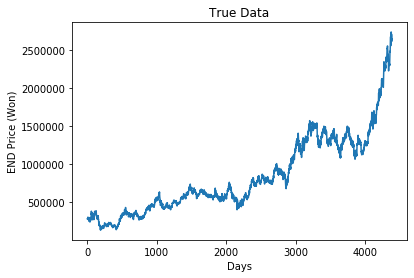

In [89]:
plt.figure()
plt.plot(DATA["Close"])
plt.title('True Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

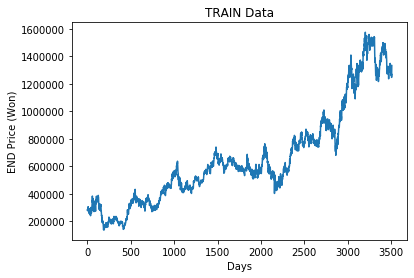

In [90]:
plt.figure()
plt.plot(TRAIN_DF["Close"])
plt.title('TRAIN Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

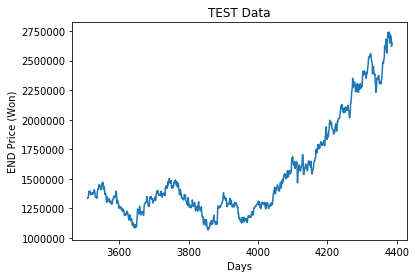

In [91]:
plt.figure()
plt.plot(TEST_DF["Close"])
plt.title('TEST Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

## 데이터 가공해서 뿌려주는 함수들

### `makeInputUnits(whole, given, predicting)`
makeInputUnits는 연속된 전체 데이터(`whole`)를 이용해서 Input Unit의 배열을 만들어내는 함수이다. 

리턴하는 두 개의 값은 각각 given개의 데이터 리스트와, 이후 `predicting`개 데이터의 종가 값을 linearly regress한 기울기이다(스칼라).

In [0]:
def getRegressedSlope(data, fromIdx, cnt):
  # -1 because regressor must use zeroth data point as pivot of regressed line.
  # 0 is index of closing price, which is target of regression.
  DD = data[fromIdx - 1 : fromIdx + cnt, 0]
  reg = sklm.LinearRegression()
  # 0th element's weight is infinite, because the regressed line must start on zeroth day (which is just before prediction)
  weight = [1e-10 for _ in range(cnt + 1)]
  weight[0] = 100000000000000
  reg.fit(np.arange(cnt + 1).reshape(-1, 1) / (cnt + 1), DD, weight)
  return reg.coef_.item(0)

In [0]:
# def test():
#   testDa = np.array(
#           [[ 0,  1,  2,  3,  4],
#            [ 0,  6,  7,  8,  9],
#            [10, 11, 12, 13, 14],
#            [1000, 16, 17, 18, 19]])
#   slope, cut = getRegressedSlope(testDa, 1, 3)
#   print(slope, cut)
#   fig = go.Figure()
#   fig.add_scatter(y=testDa[:, 0], name="Points")
#   reged = []
#   for xx in range(0, testDa.shape[0], 1):
#     reged.append(slope * xx + cut)
#   fig.add_scatter(y=reged, name="reged")
#   fig.show()

In [0]:
def makeInputUnits(whole, given, predicting):
  entryCnt = whole.shape[0]
  entryDim = whole.shape[1]

  unitLen = given + predicting
  unitCnt = entryCnt - unitLen + 1

  givenEntries = np.zeros((unitCnt, given, entryDim))
  predictEntries = np.zeros((unitCnt))

  for idx in range(unitCnt):
    givenEntries[idx] = whole[idx : idx + given]
    predictEntries[idx] = getRegressedSlope(whole, idx + given, predicting)
  
  return givenEntries, predictEntries

### `makeBatches(givens, predicts, b_size, shuffle=False)`

`makeInputUnits`에서 만든 input unit들을 서로 묶어서 batch로 만들어주는 함수

`shuffle`이 `True`면 각 batch들의 순서가 무작위가 된다. 시간순으로 학습하지 않아 조금은 overfitting에 도움이 될 지도.

In [0]:
def makeBatches(givens, predicts, b_size, shuffle=False):
  unitCnt = givens.shape[0]
  unitsLeft = unitCnt

  unitPointer = 0

  toReturn = []

  while unitsLeft >= b_size:
    retBatchGivens = givens[unitPointer : unitPointer + b_size]
    retBatchPredicts = predicts[unitPointer : unitPointer + b_size]

    unitsLeft = unitsLeft - b_size
    unitPointer = unitPointer + b_size
    
    toReturn.append((torch.Tensor(retBatchGivens.swapaxes(0, 1)), torch.Tensor(retBatchPredicts).reshape(b_size, 1).to(device)))
  
  if shuffle:
    random.shuffle(toReturn)

  for tup in toReturn:
    yield tup


## 테스트

In [13]:
G, P = makeInputUnits(TRAIN, GivenCnt, PredictCnt)
batIter = makeBatches(G, P, BatchSize)
GG, PP = None, None
for bat in batIter:
  GG, PP = bat
  print(GG.shape)
  print(PP.shape)
  break

fig = go.Figure()
fig.add_scatter(y=TRAIN[:, 0], name="givens")

# show only 0th batch.
fig.update_layout(
  shapes=[
    go.layout.Shape(
      type="line",
      x0=GivenCnt - 1,
      y0=GG[GivenCnt - 1, 0, 0],
      x1=GivenCnt + PredictCnt,
      y1=GG[GivenCnt - 1, 0, 0] + PP[0].item(),
      line=dict(
          color="red",
          width=1
      )
    )     
  ]
)
fig.show()

torch.Size([100, 32, 4])
torch.Size([32, 1])


# 2. 모델 만들기

## 모델 코드

LSTM의 output에 대해,

*   dropout
*   Fully Connected layer
*   Activation layer (ReLU)
*   Fully connected

을 거친 값이 model의 output이 되고, 그 값은 이후 `PredictCnt`개의 종가를 regression한 기울기가 됨.



In [0]:
class GrandPredictor(nn.Module):
  def __init__(self, hiddenSize=16, dropoutRate=0.2, FcHiddenSize=16):
    super(GrandPredictor, self).__init__()
    self.lstm = nn.LSTMCell(UsingColsCnt, hiddenSize)
    self.dropout = nn.Dropout(p=dropoutRate)
    self.Fc_mid = nn.Linear(hiddenSize, FcHiddenSize)
    self.relu = nn.ReLU()
    self.Fc_out = nn.Linear(FcHiddenSize, 1)

  def forwardAfterLSTM(self, x):
    x = self.dropout(x)
    x = self.relu(self.Fc_mid(x))
    return self.Fc_out(x)

  def forward(self, givens, predictCnt):
    givens = givens.to(device)
    
    h, c = None, None

    for G in givens:
      if h is None or c is None:
        h, c = self.lstm(G)
      else:
        h, c = self.lstm(G, (h, c))

    # output P is scalar.
    P = self.forwardAfterLSTM(h)
    return P

## 모델 제작 및 Optimizer 생성

In [15]:
predictor = GrandPredictor(HiddenSize_1, DropoutRate, HiddenSize_2)
predictor = predictor.to(device)
print(predictor)
optimizer = optim.RMSprop(predictor.parameters(), lr=LearningRate)

GrandPredictor(
  (lstm): LSTMCell(4, 64)
  (dropout): Dropout(p=0, inplace=False)
  (Fc_mid): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (Fc_out): Linear(in_features=64, out_features=1, bias=True)
)


## 모델 테스트(오류 없이 돌아가는가)

In [16]:
predictor(torch.zeros((GivenCnt, BatchSize, UsingColsCnt)), PredictCnt).shape

torch.Size([32, 1])

# 3. Training

## Checkpoint Load
체크포인트 경로는 파일 최상단 config 부분에서 수정

In [17]:
ckpt_path = CHECKPOINT_PATH
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    predictor.load_state_dict(ckpt['predictor'])
    optimizer.load_state_dict(ckpt['optimizer'])
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')

checkpoint is loaded !


## Training Code

In [101]:
# Training process
losses = []
prices = []

givenSets, trueSets = makeInputUnits(TRAIN, GivenCnt, PredictCnt)

predictor.train()
it = 0
for epoch in trange(MaxEpoch):
  batchIter = makeBatches(givenSets, trueSets, BatchSize, True)

  for bat in batchIter:
    it = it + 1

    givenData, trueData = bat

    predictedData = predictor(givenData, PredictCnt)

    loss = F.l1_loss(predictedData, trueData)  

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

fig = go.Figure(go.Scatter(y=losses))
fig.show()

## Checkpoint Saver
결과가 좋다면 체크포인트를 저장하자.

In [0]:
ckpt_path = CHECKPOINT_PATH
ckpt = {'predictor':predictor.state_dict(),
        'optimizer':optimizer.state_dict()}
torch.save(ckpt, ckpt_path)

# 4. Test

### `drawTestLossFig()` **!!!Training을 했을 때만 사용 가능!!!**

Draw the loss graph of TEST dataset.

Overfitting을 확인하는 데에 유용함.

In [18]:
def drawTestLossFig():
  predictor.eval()

  losses_test = []
  givenSets, trueSets = makeInputUnits(TEST, GivenCnt, PredictCnt)
  batIter = makeBatches(givenSets, trueSets, BatchSize)

  for batch in batIter:
    givenData, trueData = batch
    predictedData = predictor(givenData, PredictCnt)
    loss = F.l1_loss(predictedData, trueData)

    losses_test.append(loss.item())
  
  fig = go.Figure()
  fig.add_scatter(y=losses[-len(losses_test):], name="training")
  fig.add_scatter(y=losses_test, name="test")
  fig.show()

drawTestLossFig()

NameError: ignored

### `drawStepFig()`
예측한 slope와 true slope값을 보여줌

In [0]:
def drawStepFig():
  predictor.eval()

  givenSets, trueSets = makeInputUnits(TEST, GivenCnt, PredictCnt)
  batIter = makeBatches(givenSets, trueSets, 1)
  predSlope = []
  trueSlope = []
  day = GivenCnt - 1
  for batch in batIter:
    Gset, Tset = batch
    predSlope.append(predictor(Gset, PredictCnt)[0, 0].item())
    trueSlope.append(Tset[0, 0].item())

  # plt.figure(figsize=(30, PredictCnt * 6))
  
  fig = go.Figure()
  fig.add_scatter(y=trueSlope, name='True values')
  fig.add_scatter(y=predSlope, name='Predicted')
  fig.update_layout(
    title={
        'text': "Estimations",
        'yanchor': 'top'})
  return fig

## 5. 테스트 결과 저장
Plotly가 매우 편하다^^

In [20]:
fig = drawStepFig()
fig.show()

In [21]:
fig.update_layout(
  title={
      'text': printConfig(),
      'x' : 0,
      'xanchor': 'left',
      'yanchor': 'top'},
  font={
      'size':9
  })
plty.offline.plot(fig, filename = os.path.join(RESULT_DIR, 'REG-long predict.html'), auto_open=True)

'/gdrive/My Drive/Project/ResultGraphs/REG-long predict.html'